In [43]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from terminal.Extensions.MT5 import MT5

In [44]:
MT5.initialize()

In [77]:
from_date = datetime(2024, 6, 18, hour=6, tzinfo=pytz.utc)
to_date = datetime(2024, 6, 19, tzinfo=pytz.utc)

trades_list = None

while from_date < to_date:
    trades = mt5.copy_ticks_range(
        "WIN$N", from_date, from_date.replace(hour=23), mt5.COPY_TICKS_TRADE
    )
    if mt5.last_error()[0] == mt5.RES_S_OK and len(trades.shape) == 1:
        if trades_list is None:
            trades_list = trades
        else:
            trades_list = np.append(trades_list, trades)
    from_date += timedelta(days=1)
    del trades

In [81]:
ohlc = MT5.create_ohlc_from_ticks(trades_list, "20s")
ohlc["sma"] = ohlc["close"].rolling(30).mean().shift(1)
ohlc["smaFast"] = ohlc["close"].rolling(10).mean().shift(1)

array([<Axes: xlabel='time_msc'>], dtype=object)

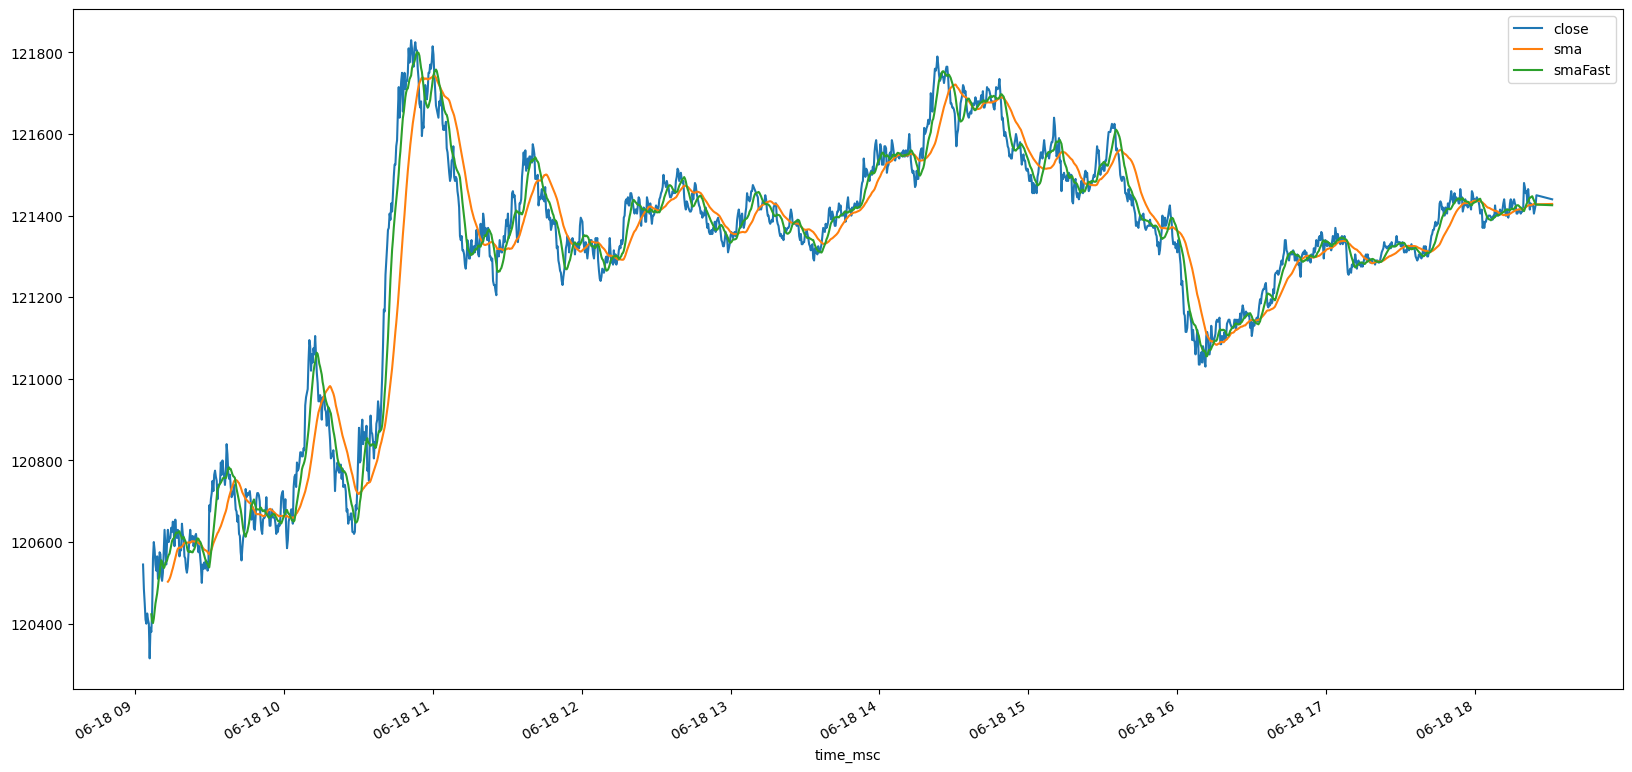

In [82]:
ohlc[["close", "sma", "smaFast"]].plot(figsize=(20, 10), subplots=[("close", "sma", "smaFast")])

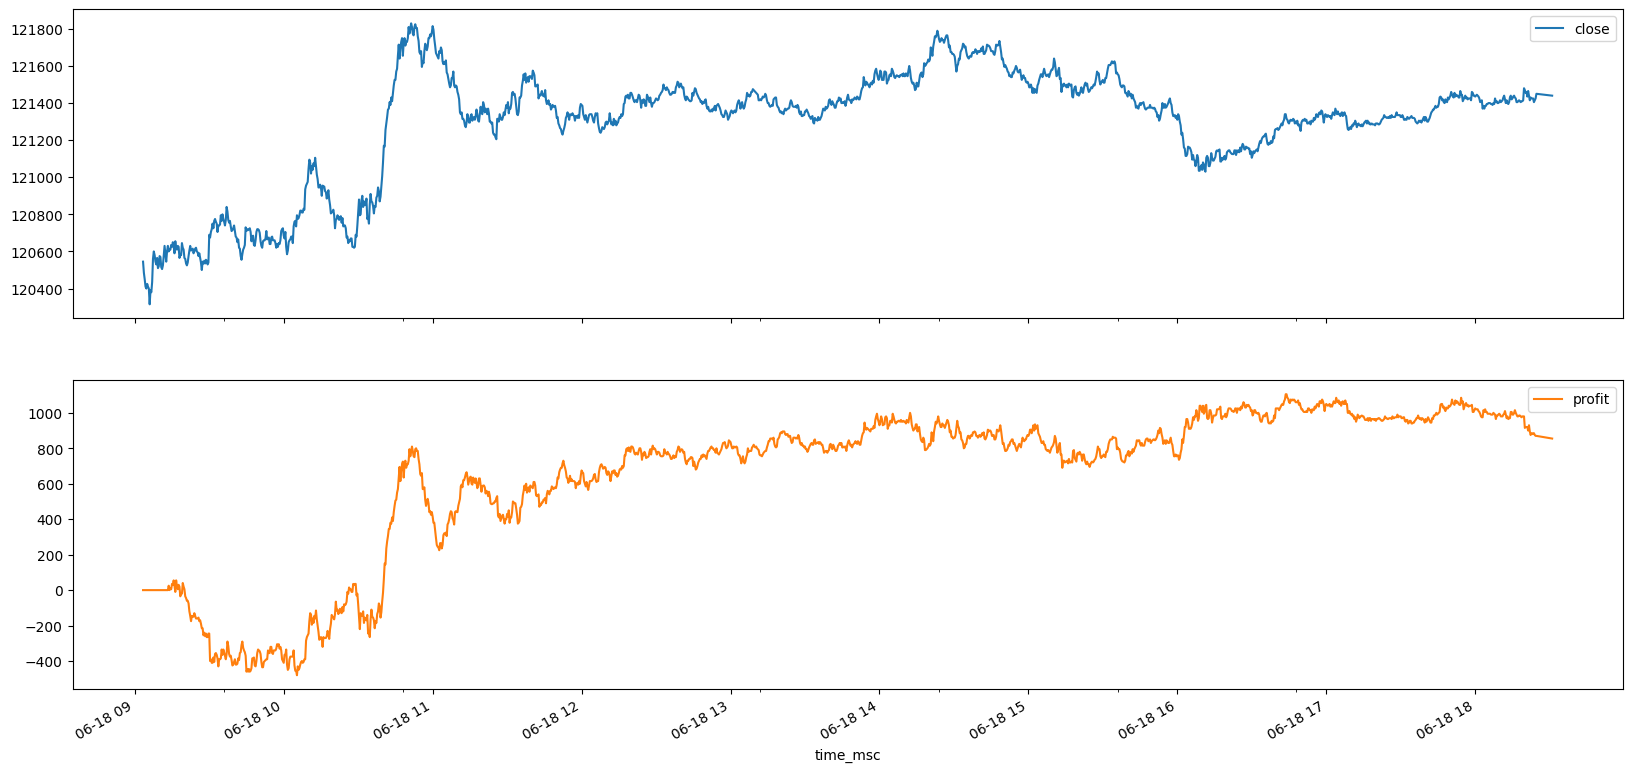

In [83]:
temp = ohlc.copy()

temp["position_side"] = np.nan
temp["position"] = np.nan
temp["profit"] = np.nan

position_side = 0  # 1 = BUY, -1 = SELL

for i, item in temp.iterrows():
    if position_side == 0 and item["smaFast"] > item["sma"]:  # buy
        temp.loc[i, "position"] = item["open"] * -1
        position_side = 1
    elif position_side == 1 and item["smaFast"] < item["sma"]:  # close buy
        temp.loc[i, "position"] = item["open"] 
        position_side = 0
    elif position_side == 0 and item["smaFast"] < item["sma"]:  # sell
        temp.loc[i, "position"] = item["open"] 
        position_side = -1
    elif position_side == -1 and item["smaFast"] > item["sma"]:  # close sell
        temp.loc[i, "position"] = item["open"] * -1
        position_side = 0

    temp.loc[i, "position_side"] = position_side
    temp.loc[i, "profit"] = temp.loc[:i]["position"].sum()

    if position_side == 1:
        temp.loc[i, "profit"] = temp.loc[i, "profit"] - temp.loc[i, "open"] * -1
    elif position_side == -1:
        temp.loc[i, "profit"] = temp.loc[i, "profit"] - temp.loc[i, "open"]

temp[["close", "profit"]].plot(figsize=(20, 10), subplots=[("close",), ("profit",)])
temp.to_excel("bricks.xlsx")